In [7]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

import random

#

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix

#

from bayes_opt import BayesianOptimization

#

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from cartopy.io.img_tiles import OSM, GoogleTiles, StadiaMapsTiles, MapQuestOSM

from pandasgui import show

#

import warnings

In [8]:
gmID_list = cfs.list_whitelisted_gmIDs_with_traffic_data()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [4]:
moving_window = 10 # seconds

expansion_window = 1e9 # nanoseconds

#

red_preprocessed_dfs = []

green_preprocessed_dfs = []

blue_preprocessed_dfs = []

for gmID in gmID_list:

    preprocessed_df = cfs.retrieve_gmID_preprocessed_moving_data( gmID, window_seconds = moving_window )

    #

    cfs.BinaryDisengagementExpanded( preprocessed_df, moving_colname = 'time', window = expansion_window )

    #

    cfs.DisengagementID( preprocessed_df, expanded = False )

    cfs.DisengagementID( preprocessed_df, expanded = True )

    #

    if ( cfs.give_route( gmID ) == 'Red' ):

        red_preprocessed_dfs.append( preprocessed_df )

    elif ( cfs.give_route( gmID ) == 'Green' ):

        green_preprocessed_dfs.append( preprocessed_df )

    elif ( cfs.give_route( gmID ) == 'Blue' ):

        blue_preprocessed_dfs.append( preprocessed_df )

In [19]:
red_train_gmIDs = [ 
'61b12e7a-f234-11ee-bb33-fb353e7798cd',
'fcc6fcd2-f013-11ee-b966-fb353e7798cd',
'05c7c824-cab8-11ee-aa4d-1d66adf2f0c7',
'211bdb36-f0da-11ee-ba1b-fb353e7798cd',
'868de15e-f3b3-11ee-bb4e-fb353e7798cd',
'72a03d4a-efe9-11ee-b966-fb353e7798cd',
'7fb7b9c0-c881-11ee-a7fc-dd032dba19e8',
'96f7a614-f549-11ee-8afa-cb629b0d53e6',
'1bbbfbae-c839-11ee-a7fc-dd032dba19e8',
'622bd2e8-f0e4-11ee-ba1f-fb353e7798cd',
'9798fe24-f143-11ee-ba78-fb353e7798cd',
'88dd6fbe-f224-11ee-bb21-fb353e7798cd',
'c9c6856c-d33c-11ee-b437-336917683bb8',
'd12cd1c4-caec-11ee-909c-e1dc60cf66f9',
'817d6848-efb6-11ee-b966-fb353e7798cd',
'1b6aca0e-efdf-11ee-b966-fb353e7798cd',
'41b67a28-f52f-11ee-8afa-cb629b0d53e6',
'fc211bb2-efca-11ee-b966-fb353e7798cd',
'84d96f18-f214-11ee-bb13-fb353e7798cd',
'fe973c9c-f53c-11ee-8afa-cb629b0d53e6',
'3151e9e2-eff3-11ee-b966-fb353e7798cd',
'c0555ef0-f50f-11ee-8afa-cb629b0d53e6',
'f711e68e-f0e1-11ee-ba1f-fb353e7798cd',
'c338788a-d324-11ee-b437-336917683bb8',
'd21965e6-f0fa-11ee-ba37-fb353e7798cd',
'88a68dd8-eef9-11ee-9385-ef789ffde1d3',
'f41cbd44-eff8-11ee-b966-fb353e7798cd',
'43a1a35e-f362-11ee-bb4e-fb353e7798cd',
'6d2ea45a-c839-11ee-a7fc-dd032dba19e8',
'01e65360-efd4-11ee-b966-fb353e7798cd',
'7cbd932e-f244-11ee-bb3f-fb353e7798cd',
'65cfbfd6-f396-11ee-bb4e-fb353e7798cd',
'94c53148-eeed-11ee-9385-ef789ffde1d3',
'fd1ab258-efa7-11ee-b966-fb353e7798cd',
'e7b934a8-ef1a-11ee-9385-ef789ffde1d3',
'de933de8-f112-11ee-ba4d-fb353e7798cd',
'd3698592-ef9d-11ee-b966-fb353e7798cd',
'dd72fdec-f0cf-11ee-ba0d-fb353e7798cd',
'b82476fe-f1f3-11ee-baff-fb353e7798cd',
'f755cf60-f132-11ee-ba6d-fb353e7798cd',
'853ef120-cad3-11ee-909c-e1dc60cf66f9',
'f0eebb6a-f0dc-11ee-ba1e-fb353e7798cd',
'cf831f42-f353-11ee-bb4e-fb353e7798cd',
'ecebb942-f162-11ee-ba97-fb353e7798cd',
'219f7eb8-ef87-11ee-b966-fb353e7798cd',
'd24820c8-f197-11ee-babe-fb353e7798cd',
'3d2d29ec-ef95-11ee-b966-fb353e7798cd',
'457dc5ee-f02a-11ee-b966-fb353e7798cd',
'2462c9d0-eecd-11ee-9385-ef789ffde1d3',
'51ef6da6-ca9f-11ee-909c-e1dc60cf66f9',
'c25271be-f3a4-11ee-bb4e-fb353e7798cd',
'8347b862-efad-11ee-b966-fb353e7798cd',
'8dbbbf1c-f0ef-11ee-ba29-fb353e7798cd',
'9189a2a8-f121-11ee-ba5b-fb353e7798cd',
'8fa6fe80-c869-11ee-a7fc-dd032dba19e8' 
]

red_training_dfs, red_testing_dfs = [], []

for df in red_preprocessed_dfs:

    if df[ 'groupMetadataID' ][ 0 ] in red_train_gmIDs:

        red_training_dfs.append( df )

    else:

        red_testing_dfs.append( df )

In [20]:
X_colnames = [ 'speedMps', 'brakePercentage', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev', \
               'TernaryTurnSignal', 'BinaryContainLights' ]

y_colname = 'BinaryDisengagementExpanded'

In [57]:
def function_to_maximize( min_samples_split, min_samples_leaf ):

    value = cfs.BinaryClassification_DecisionTree_CV( train_dfs = red_training_dfs, \
                                                      X_colnames = X_colnames, \
                                                      y_colname = y_colname, \
                                                      metric_function = cfs.mf_fbeta_score, \
                                                      dt_random_state = 0, \
                                                      cv_num_of_splits = 10, \
                                                      cv_shuffle = False, \
                                                      cv_random_state = None, \
                                                      y_labels = [ 0, 1 ], \
                                                      criterion = 'entropy', \
                                                      min_samples_split = round( min_samples_split ),
                                                      min_samples_leaf = round( min_samples_leaf ) )

    return value

In [58]:
parameter_bounds = {
    
    'min_samples_split': ( 2, 500 ),

    'min_samples_leaf': ( 1, 500 )
}

optimizer = BayesianOptimization( f = function_to_maximize, \
                                  pbounds = parameter_bounds, \
                                  random_state = 1, \
                                  verbose = 2 )

optimizer.maximize( n_iter = 25, init_points = 25 )

best_params_bayes = optimizer.max[ 'params' ]

best_score_bayes = optimizer.max['target']

print( f'Tuned Hyperparameters: { best_params_bayes }' )

print( f'Best Balanced Accuracy: { best_score_bayes }' )

|   iter    |  target   | min_sa... | min_sa... |
-------------------------------------------------
| 1         | 0.106     | 209.1     | 360.7     |
| 2         | 0.07898   | 1.057     | 152.6     |
| 3         | 0.09963   | 74.23     | 47.98     |
| 4         | 0.1042    | 93.94     | 174.1     |
| 5         | 0.1052    | 199.0     | 270.3     |
| 6         | 0.106     | 210.2     | 343.2     |
| 7         | 0.106     | 103.0     | 439.3     |
| 8         | 0.0871    | 14.67     | 335.9     |
| 9         | 0.106     | 209.2     | 280.2     |
| 10        | 0.1007    | 71.05     | 100.7     |
| 11        | 0.1056    | 400.6     | 484.2     |
| 12        | 0.1045    | 157.4     | 346.8     |
| 13        | 0.09101   | 438.3     | 447.5     |
| 14        | 0.08667   | 43.44     | 21.45     |
| 15        | 0.1057    | 85.75     | 439.3     |
| 16        | 0.09553   | 50.08     | 211.7     |
| 17        | 0.08149   | 479.0     | 267.5     |
| 18        | 0.1052    | 346.2     | 159.1     |


In [76]:
cm_values, model, y_test, y_pred_test = BinaryClassification_DecisionTree_v2( train_dfs = red_training_dfs, \
                                                        test_dfs = red_testing_dfs, \
                                                        X_colnames = X_colnames, \
                                                        y_colname = y_colname, \
                                                        dt_random_state = 0, \
                                                        y_labels = [ 0, 1 ], \
                                                        **best_params_bayes )

tn, fp, fn, tp = cm_values.values()

In [82]:
_ = ML_metrics( tn = tn, fp = fp, fn = fn, tp = tp, beta = 1, display = True )

True_Positives: 313, False_Positives: 37
False_Negatives: 4700, True_Negatives: 4700

Positive_Precision: 0.894

Positive_Recall: 0.062

F1_Score: 0.117

Accuracy: 0.994
Balanced_Accuracy: 0.528


In [84]:
red_testing_df = pd.concat( red_testing_dfs )

#

unique_disengagement_recall_ = cfs.unique_disengagement_recall( y_true = y_test, \
                                                                y_pred = y_pred_test, \
                                                                true_DisengagementExpandedID_col = red_testing_df[ 'DisengagementExpandedID' ] )

#

del red_testing_df

for key, val in unique_disengagement_recall_.items():

    if ( key == 'unique_disengagement_recall' ):

        print( f'{ key }: { val:.3f}' )

    else:

        print( f'{ key }: { val }' )

unique_disengagement_recall: 0.241
num_of_unique_tp_DisengagementIDs: 38
num_of_unique_DisengagementIDs: 158


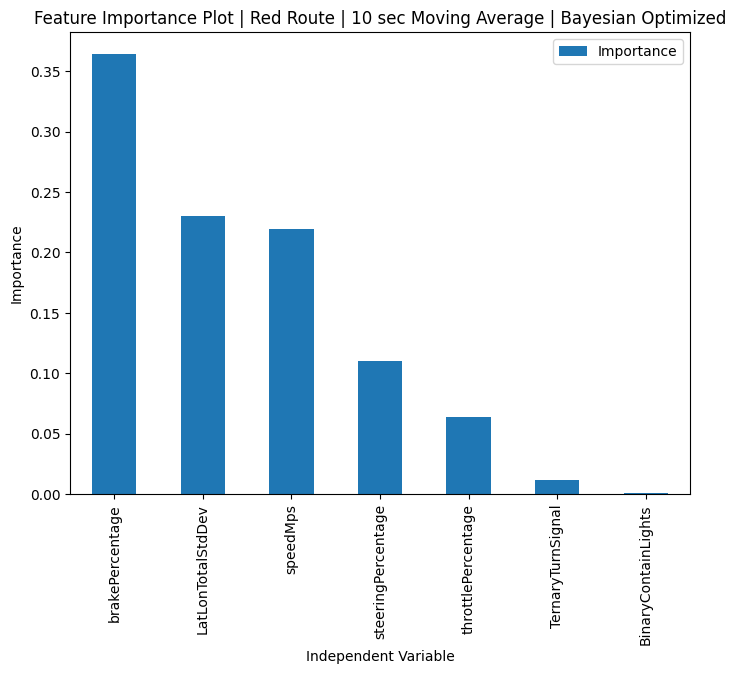

In [86]:
feat_importances = pd.DataFrame( model.feature_importances_, index = X_colnames, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot | Red Route | 10 sec Moving Average | Bayesian Optimized' )

plt.show()

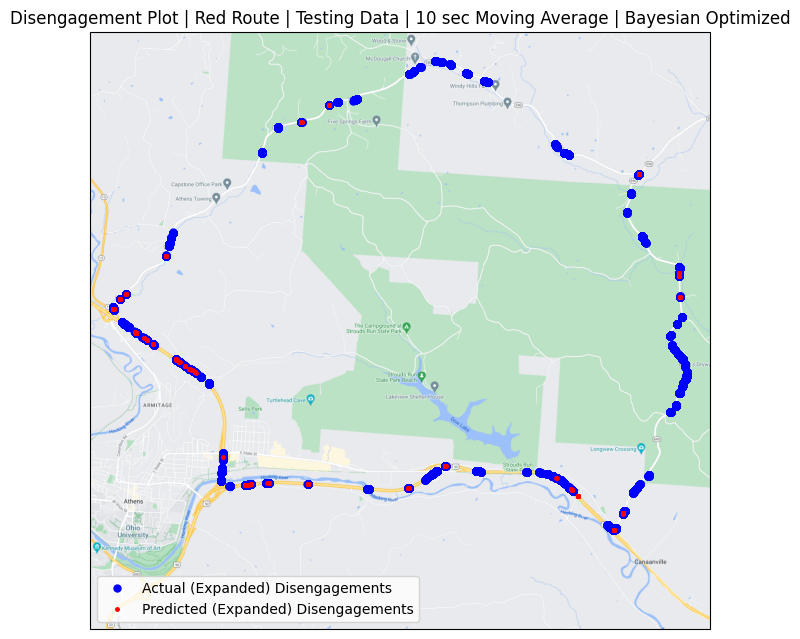

In [96]:
plt.figure( figsize = ( 8, 8 ) )

#

red_preprocessed_df = pd.concat( red_preprocessed_dfs )

#

minLat = np.min( np.array( red_preprocessed_df[ 'latitude' ] ) )

maxLat = np.max( np.array( red_preprocessed_df[ 'latitude' ] ) )

minLon = np.min( np.array( red_preprocessed_df[ 'longitude' ] ) )

maxLon = np.max( np.array( red_preprocessed_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

del red_preprocessed_df

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

red_testing_df = pd.concat( red_testing_dfs )

red_testing_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test

#

actual_disengagement_lat_list_test =  red_testing_df[ red_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

actual_disengagement_lon_list_test =  red_testing_df[ red_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  red_testing_df[ red_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

pred_disengagement_lon_list_test =  red_testing_df[ red_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

del red_testing_df

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Red Route | Testing Data | 10 sec Moving Average | Bayesian Optimized' )

plt.legend()

plt.show()

In [79]:
def BinaryClassification_DecisionTree_v2( train_dfs, \
                                       test_dfs, \
                                       X_colnames, \
                                       y_colname, \
                                       dt_random_state = 0, \
                                       y_labels = None, \
                                       **dt_hyperparameters ):

    #

    model = DecisionTreeClassifier( random_state = dt_random_state, **dt_hyperparameters )

    #

    train_df = pd.concat( train_dfs )

    test_df = pd.concat( test_dfs )

    #

    X_train, X_test = train_df[ X_colnames ], test_df[ X_colnames ]

    y_train, y_test = train_df[ y_colname ], test_df[ y_colname ]

    #

    model = model.fit( X_train, y_train )

    #

    y_pred_test = model.predict( X_test )

    #

    tn, fp, fn, tp = confusion_matrix( y_test, y_pred_test, labels = y_labels ).ravel()

    #

    return { 'tn' : tn, 'fp' : fp, 'fn' : fn, 'tp' : tp }, model, y_test, y_pred_test

In [80]:
def ML_metrics( tn, fp, fn, tp, beta, display = False ):

    #

    pprecision = cfs.mf_positive_precision( tn = tn, fp = fp, fn = fn, tp = tp )

    #

    precall = cfs.mf_positive_recall( tn = tn, fp = fp, fn = fn, tp = tp )

    nrecall = cfs.mf_negative_recall( tn = tn, fp = fp, fn = fn, tp = tp )

    #

    fbeta_score = cfs.mf_fbeta_score( tn = tn, fp = fp, fn = fn, tp = tp, beta = beta )

    #

    accuracy = cfs.mf_accuracy( tn = tn, fp = fp, fn = fn, tp = tp )

    baccuracy = cfs.mf_balanced_accuracy( tn = tn, fp = fp, fn = fn, tp = tp )

    #

    if ( display == True ):

        print( f'True_Positives: { tp }, False_Positives: { fp }' )

        print( f'False_Negatives: { fn }, True_Negatives: { fn }\n' )

        print( f'Positive_Precision: { pprecision:.3f}\n' )

        print( f'Positive_Recall: { precall:.3f}\n' )

        print( f'F{ beta }_Score: { fbeta_score:.3f}\n' )

        print( f'Accuracy: { accuracy:.3f}' )

        print( f'Balanced_Accuracy: { baccuracy:.3f}' )

    return tn, fp, fn, tp, pprecision, precall, nrecall, fbeta_score, accuracy, baccuracy